<a href="https://colab.research.google.com/github/PristRawal/Deep_Learning/blob/main/Malarial_cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-2-4152981723.py:46: UserWarning: Argument(s) 'var_range' are not valid for transform GaussNoise
  GaussNoise(var_range=(10.0, 50.0), p=0.2), # Corrected argument


Training samples: 203, Validation samples: 22


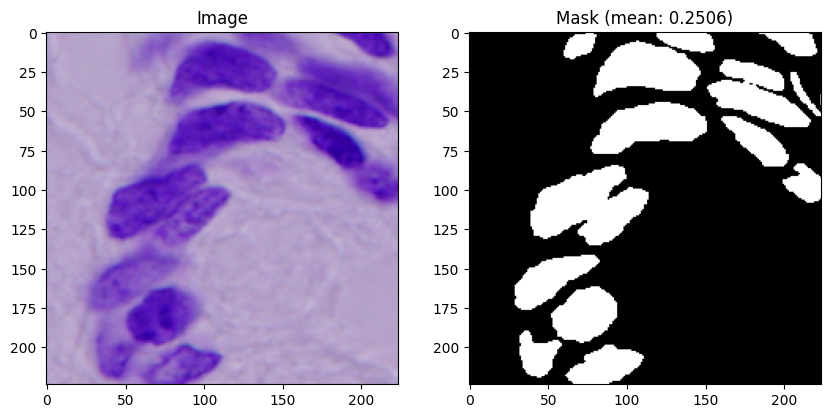

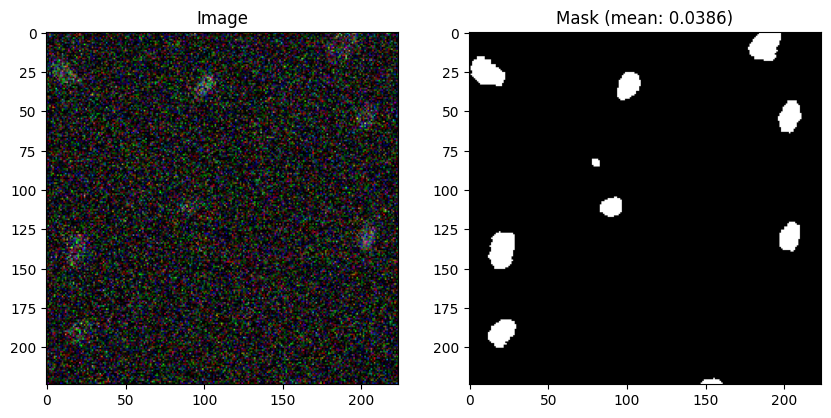

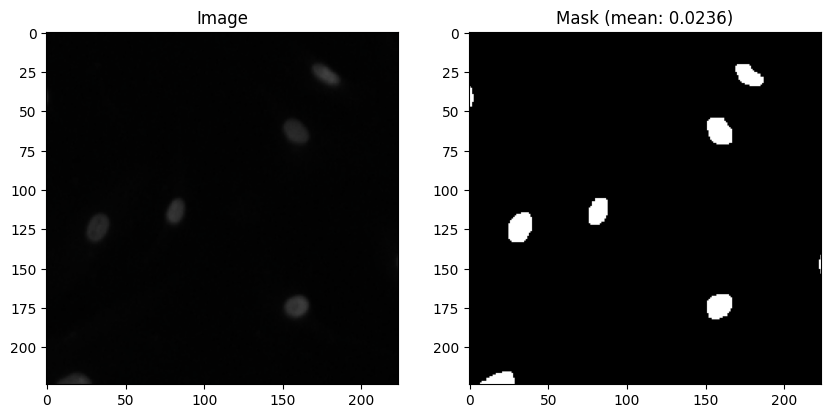


Epoch [1/20]


Train Loss: 0.7144 | Dice: 0.3853 | IoU: 0.2464
Val Loss: 0.6385 | Dice: 0.6475 | IoU: 0.4796


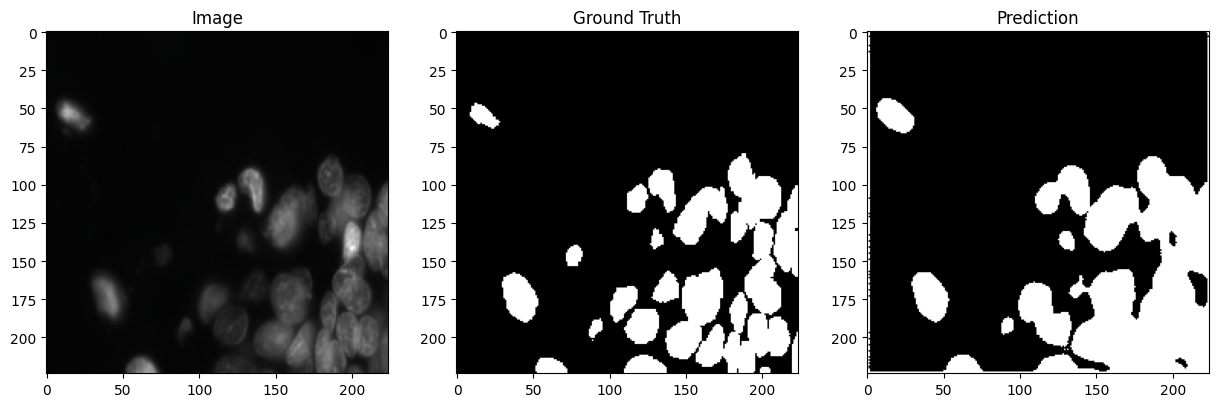

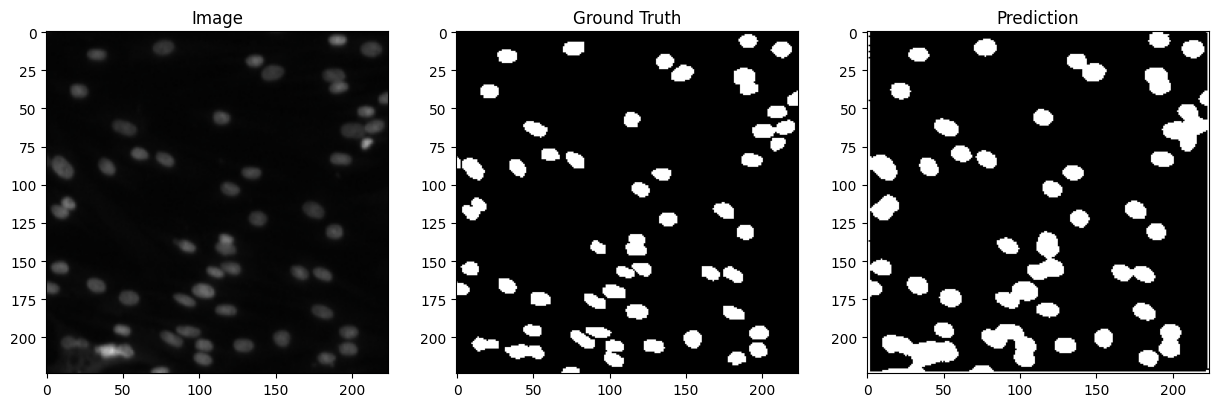

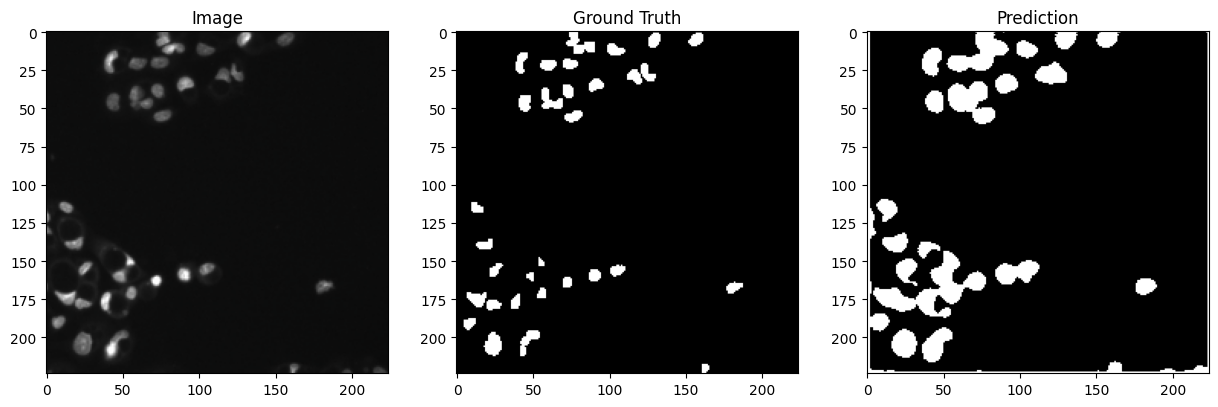

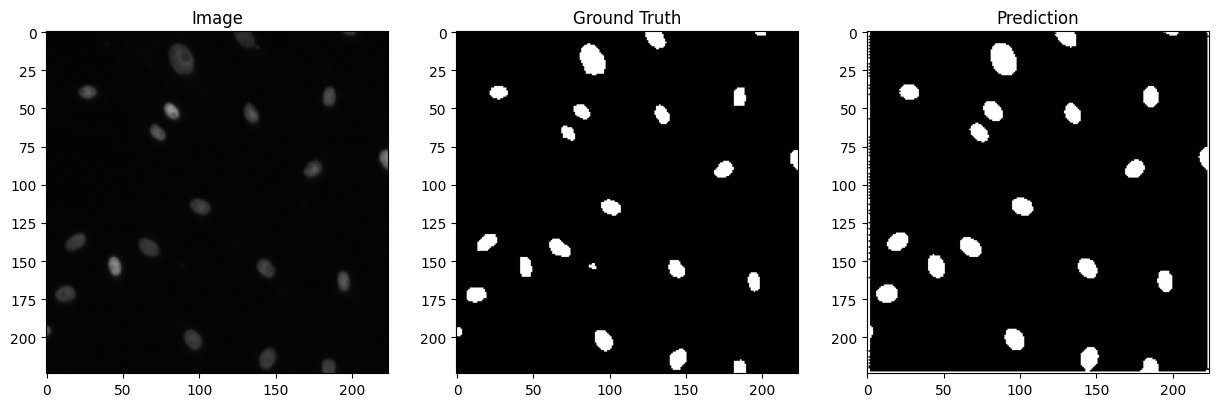

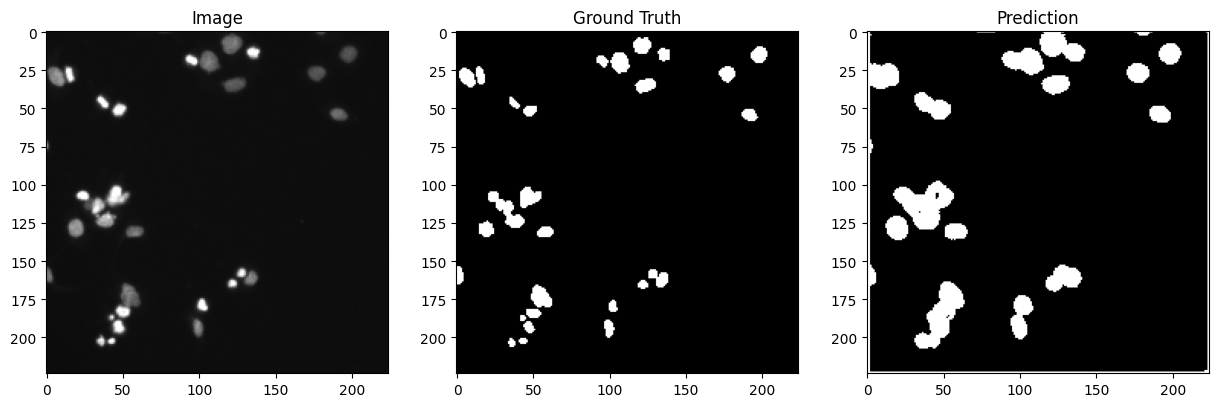

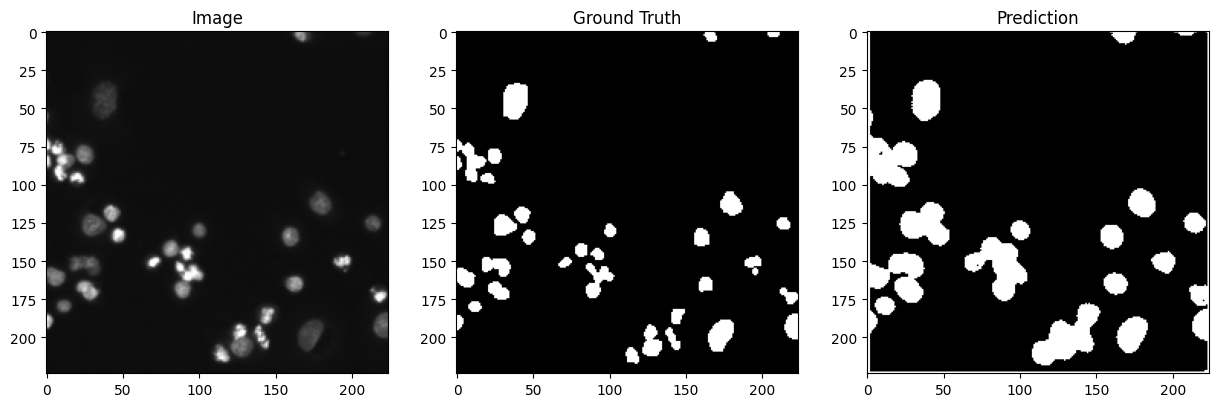


Epoch [2/20]


Train Loss: 0.5904 | Dice: 0.6128 | IoU: 0.4501
Val Loss: 0.5694 | Dice: 0.7226 | IoU: 0.5659


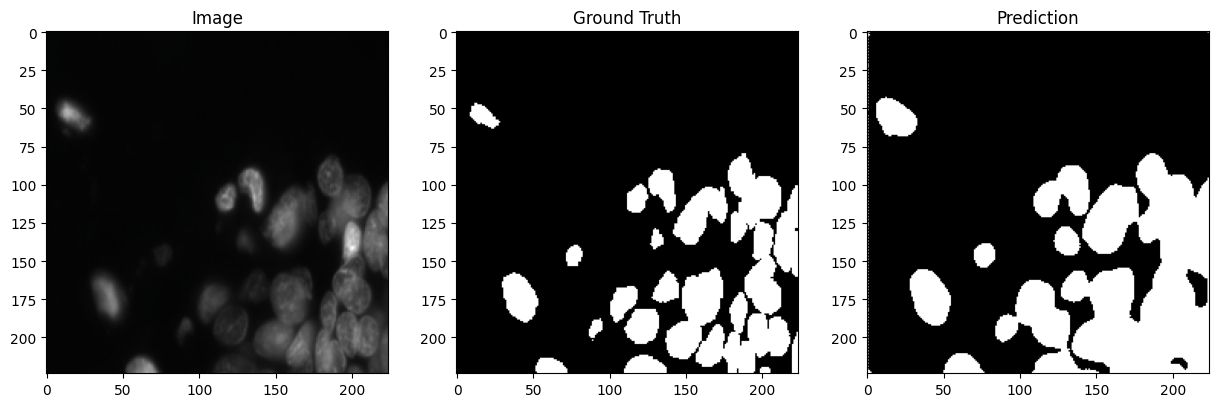

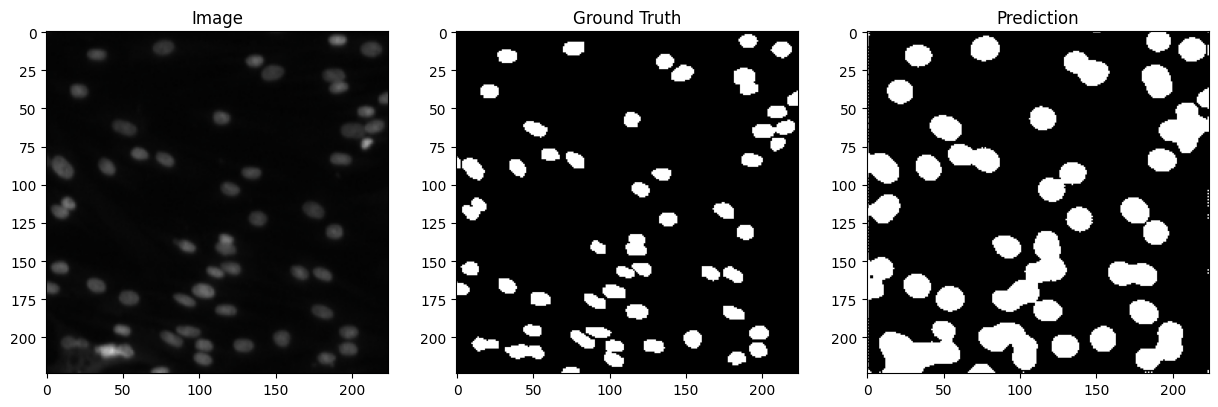

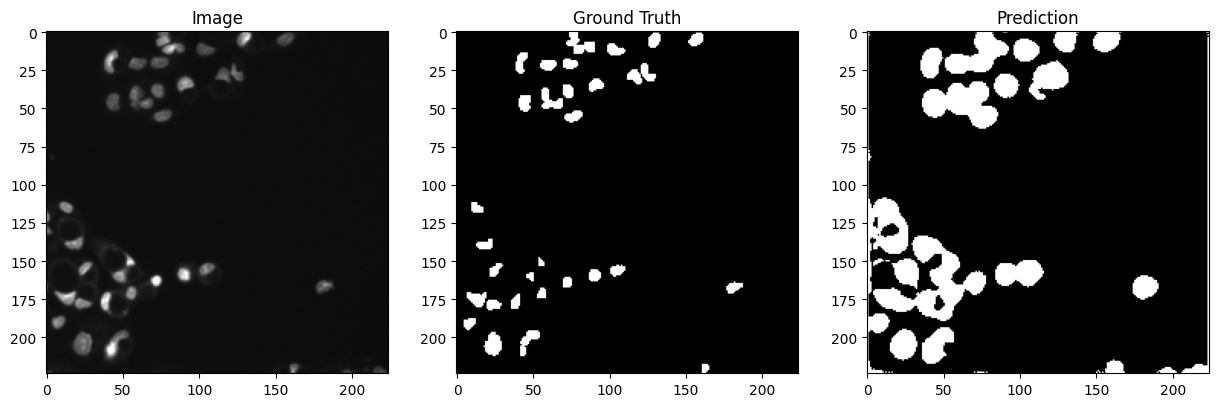

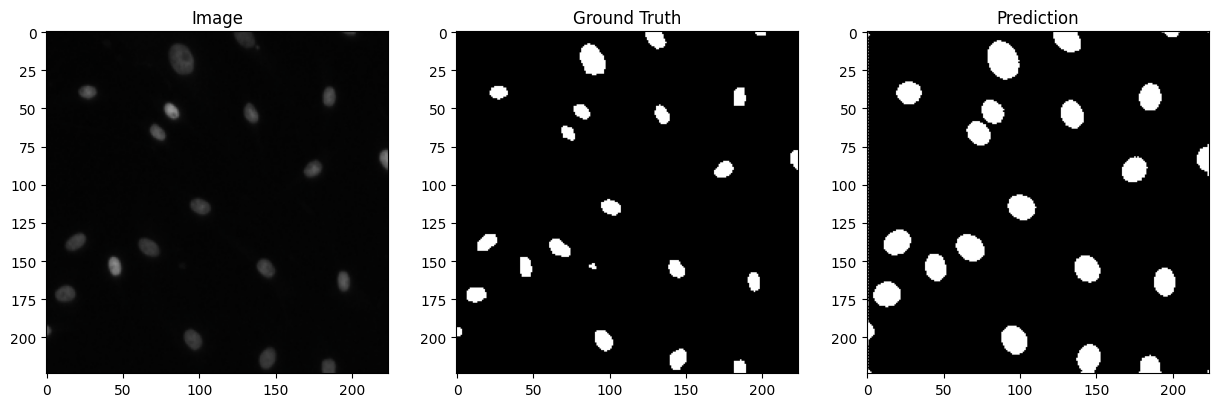

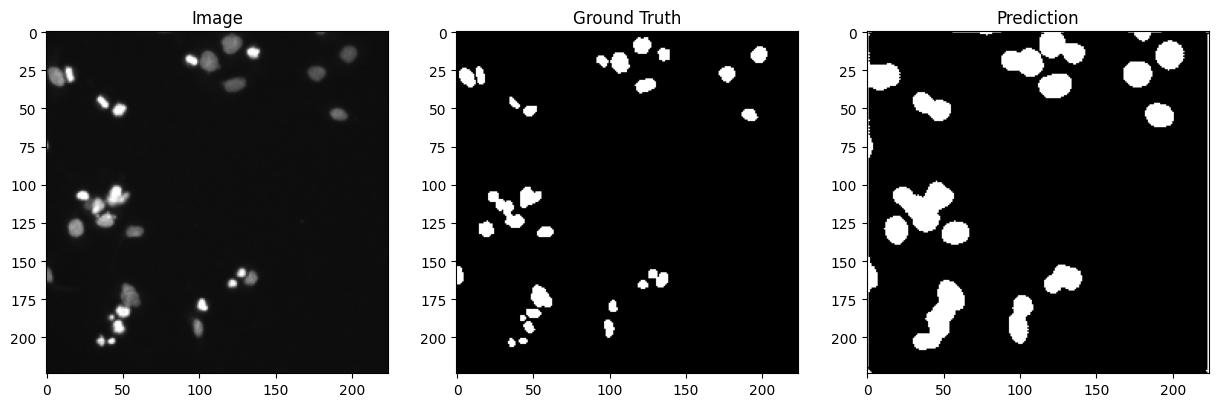

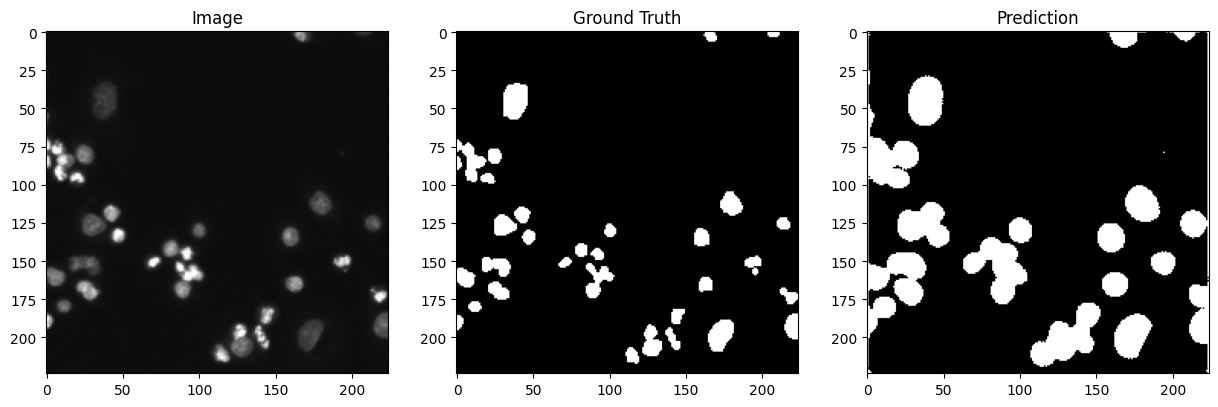


Epoch [3/20]


Train Loss: 0.5630 | Dice: 0.6519 | IoU: 0.5008
Val Loss: 0.5092 | Dice: 0.8035 | IoU: 0.6720


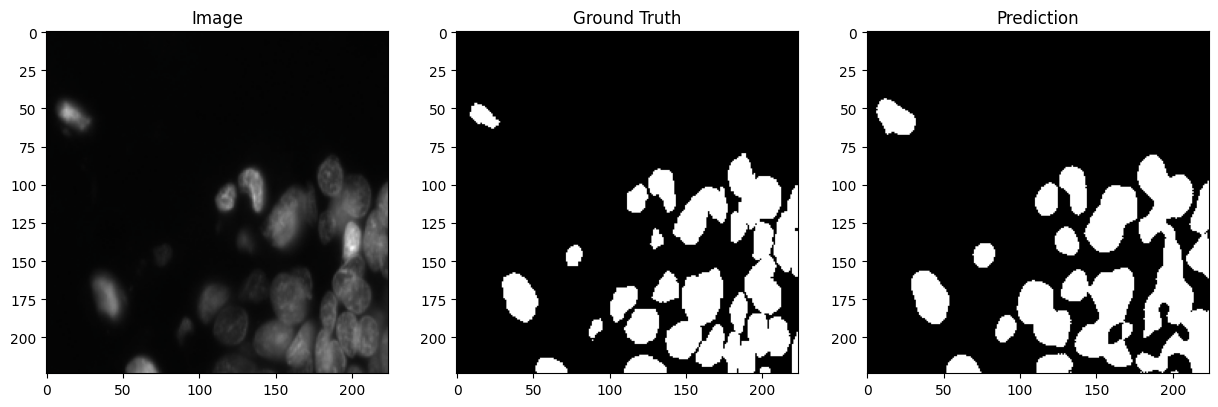

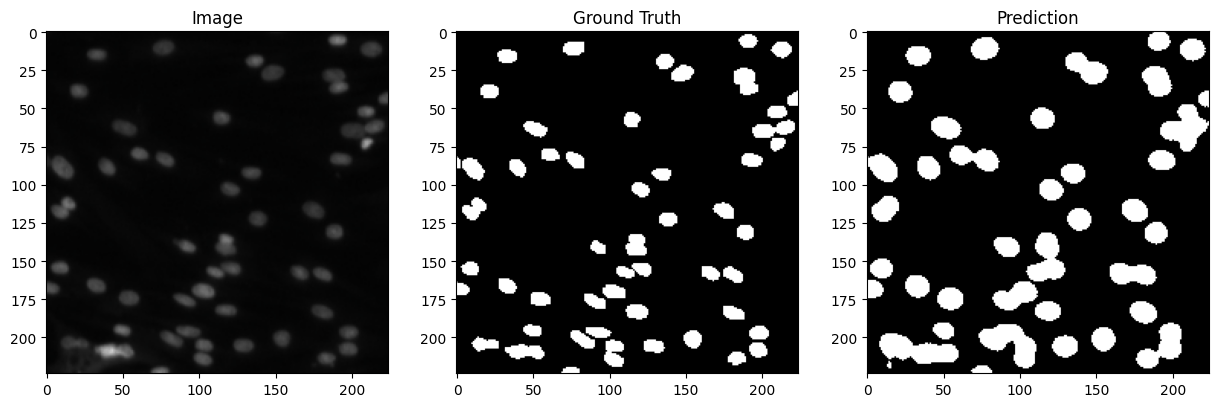

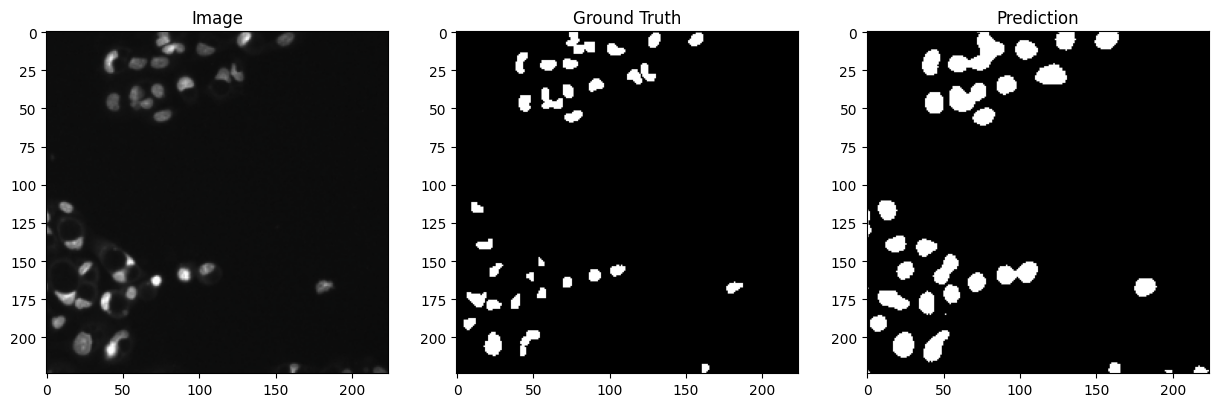

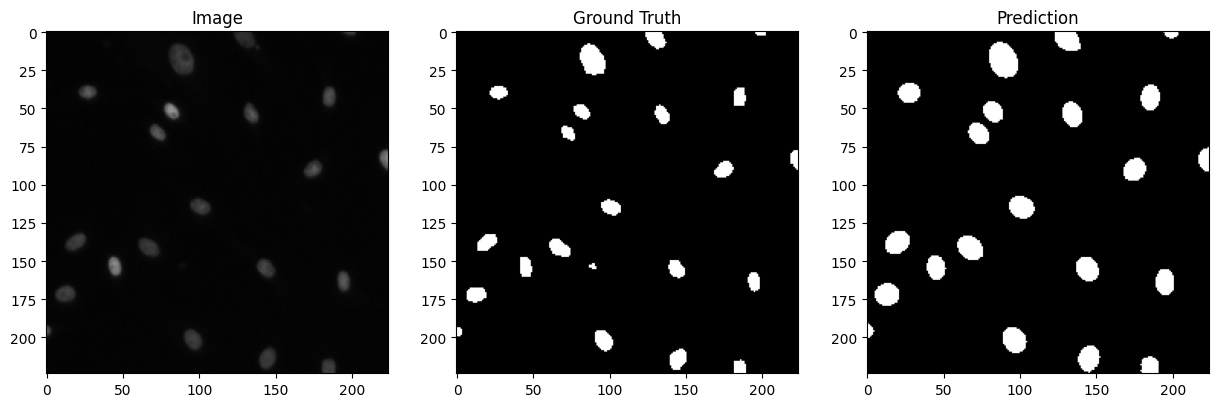

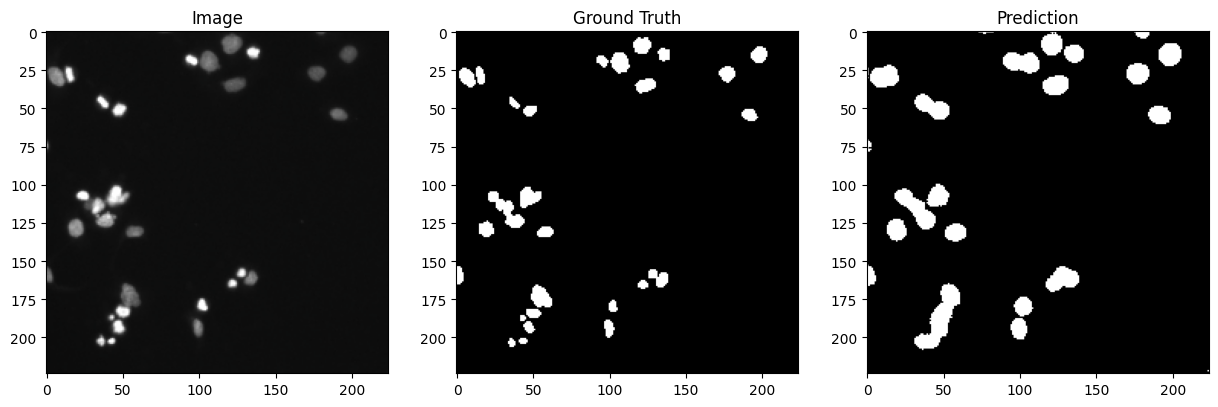

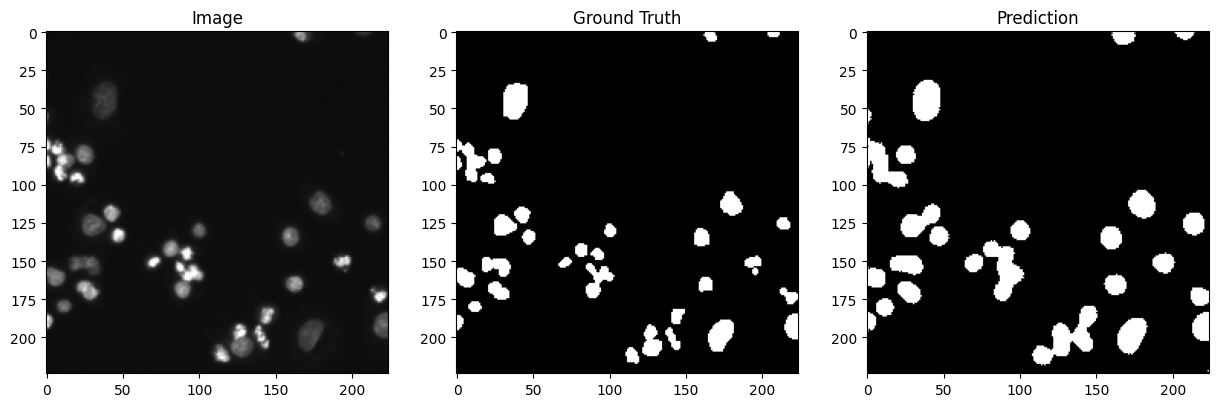


Epoch [4/20]


Train Loss: 0.5167 | Dice: 0.7461 | IoU: 0.5996
Val Loss: 0.4856 | Dice: 0.7980 | IoU: 0.6653

Epoch [5/20]


Train Loss: 0.4960 | Dice: 0.7555 | IoU: 0.6147
Val Loss: 0.4518 | Dice: 0.8379 | IoU: 0.7218


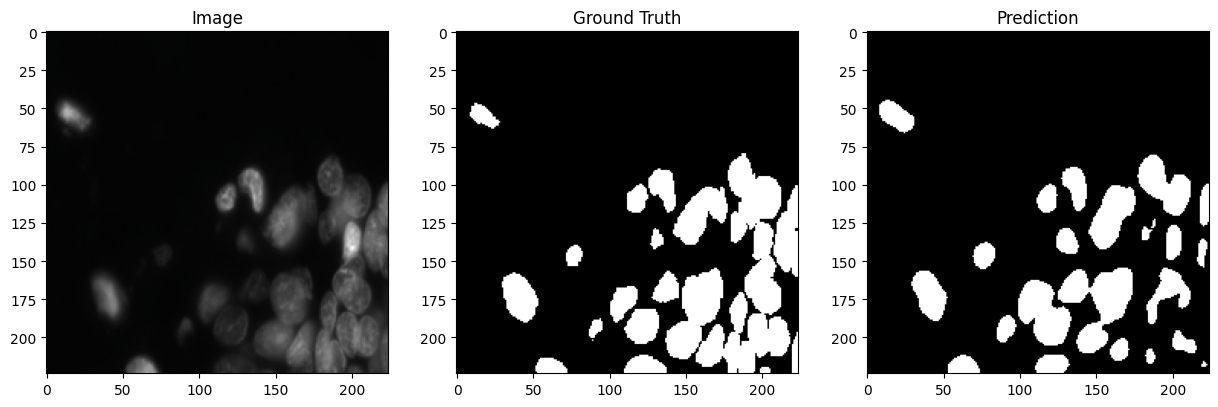

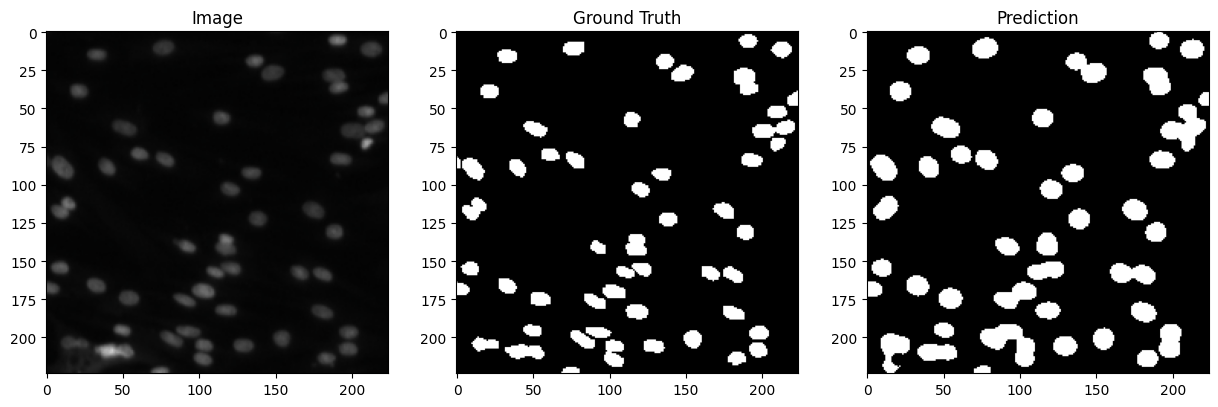

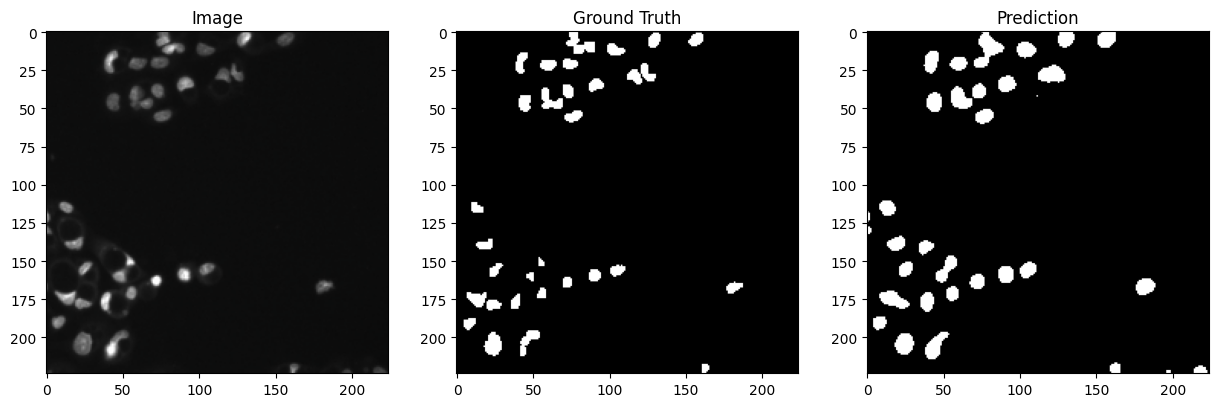

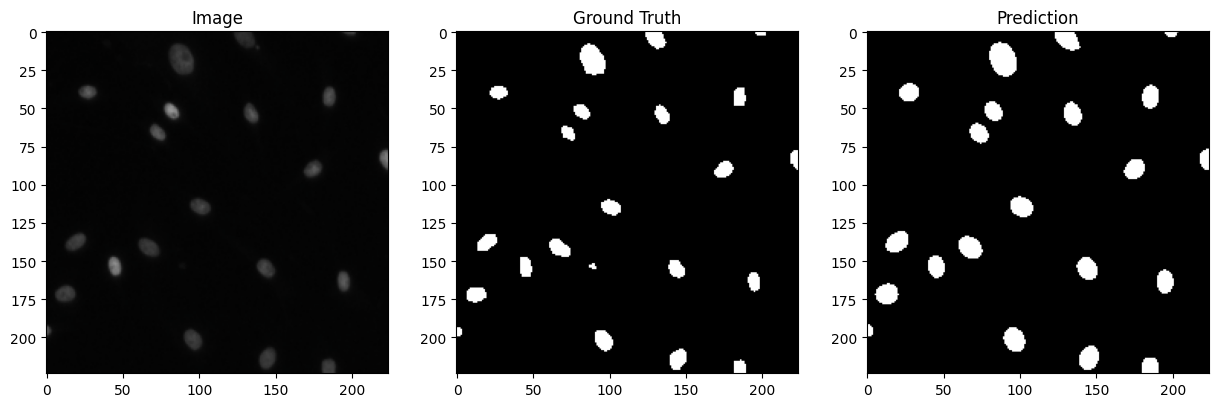

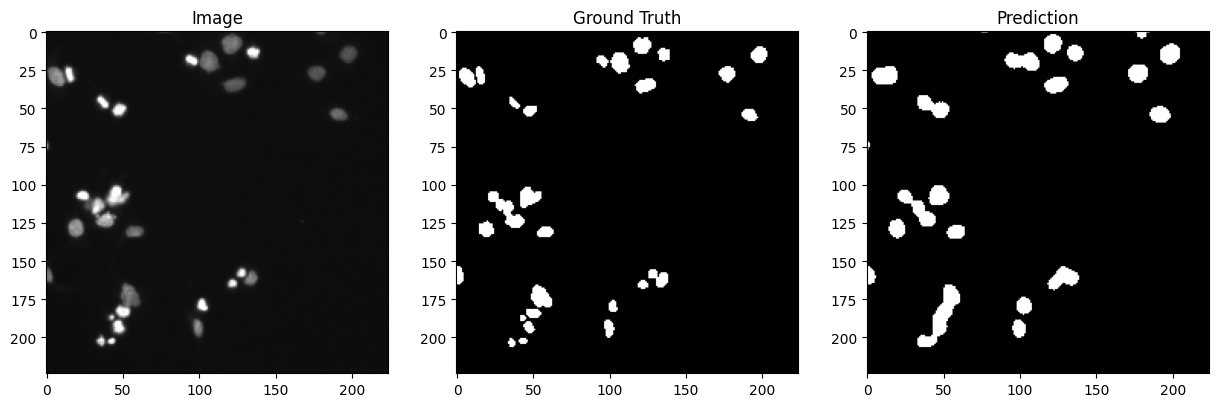

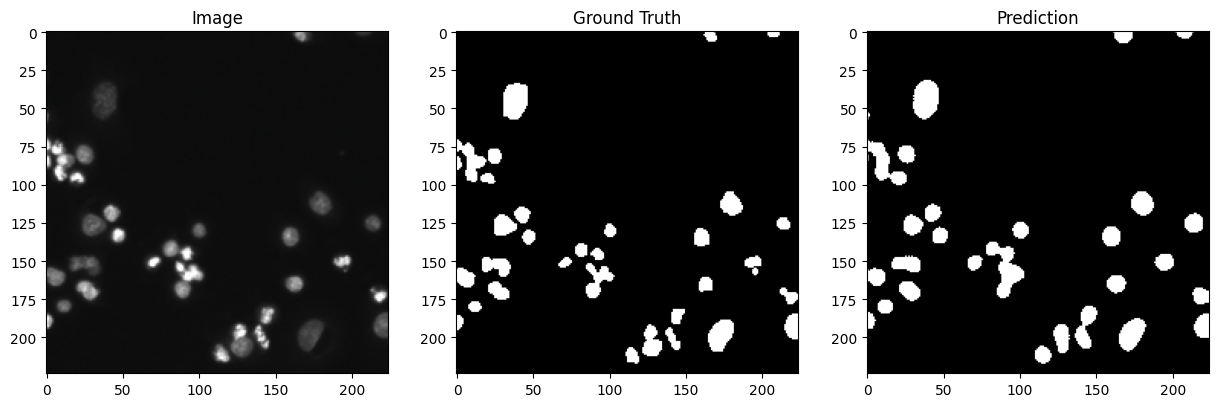


Epoch [6/20]


Train Loss: 0.4759 | Dice: 0.7802 | IoU: 0.6481
Val Loss: 0.4455 | Dice: 0.8361 | IoU: 0.7186

Epoch [7/20]


Train Loss: 0.4554 | Dice: 0.7982 | IoU: 0.6694
Val Loss: 0.4371 | Dice: 0.8470 | IoU: 0.7376


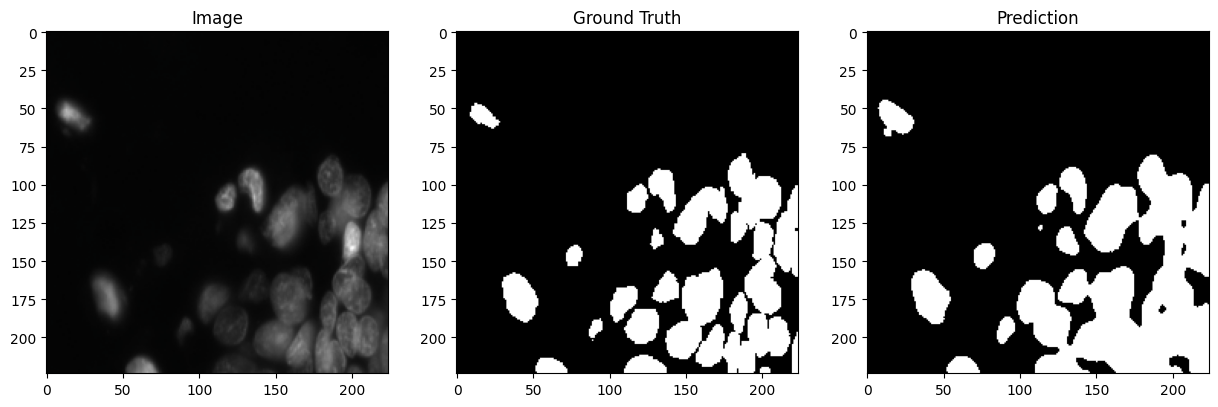

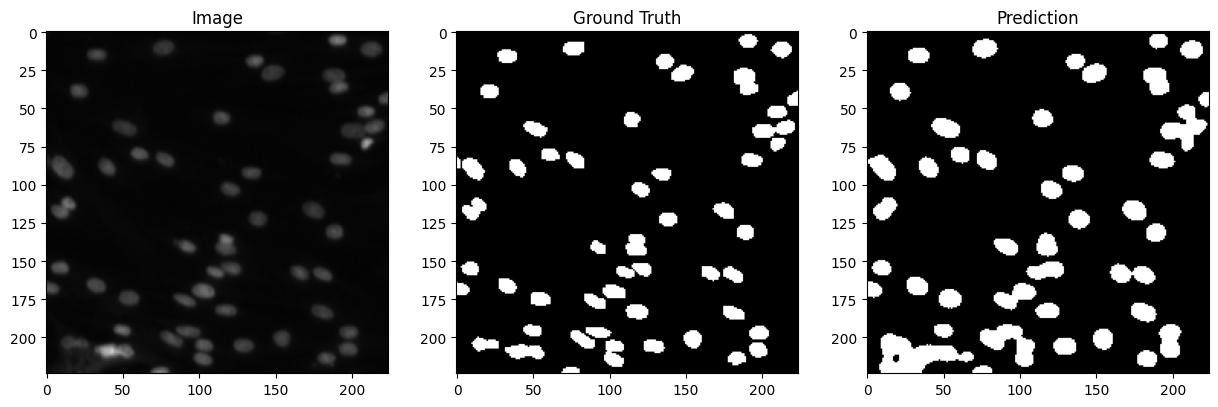

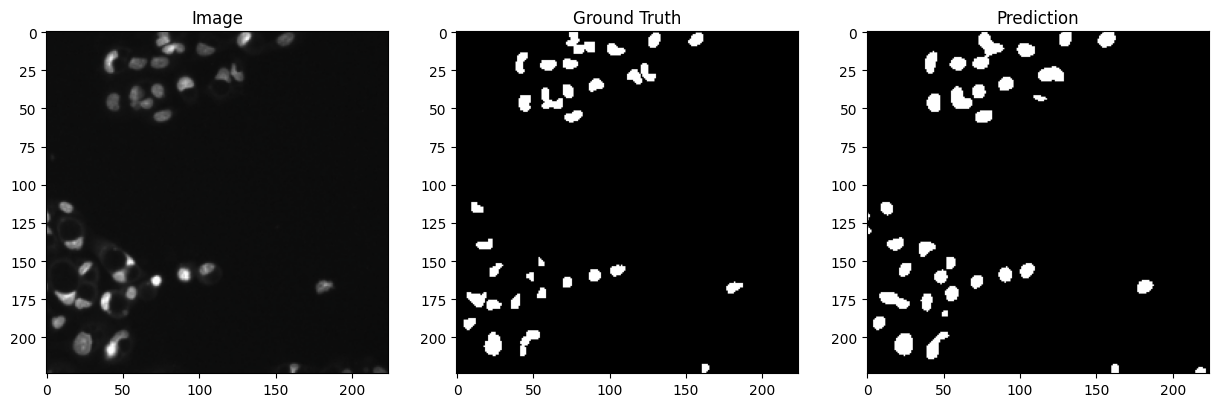

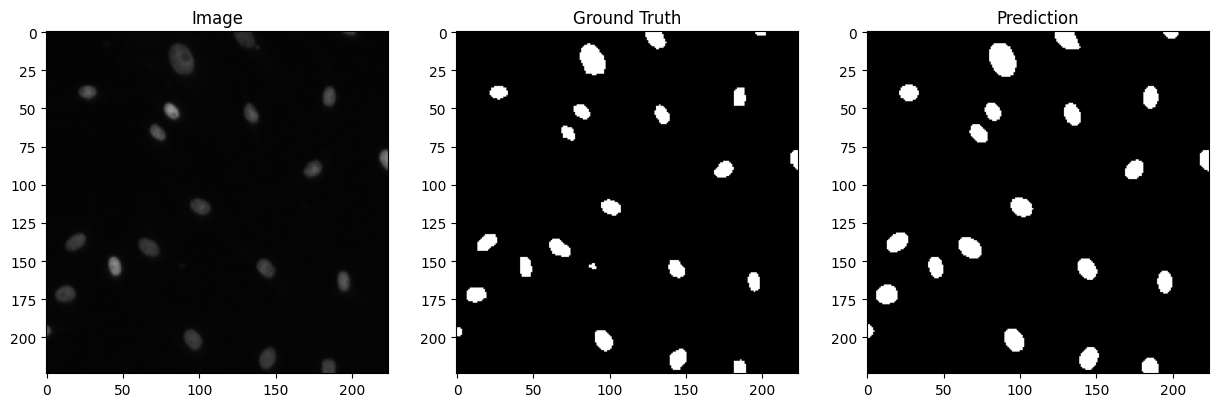

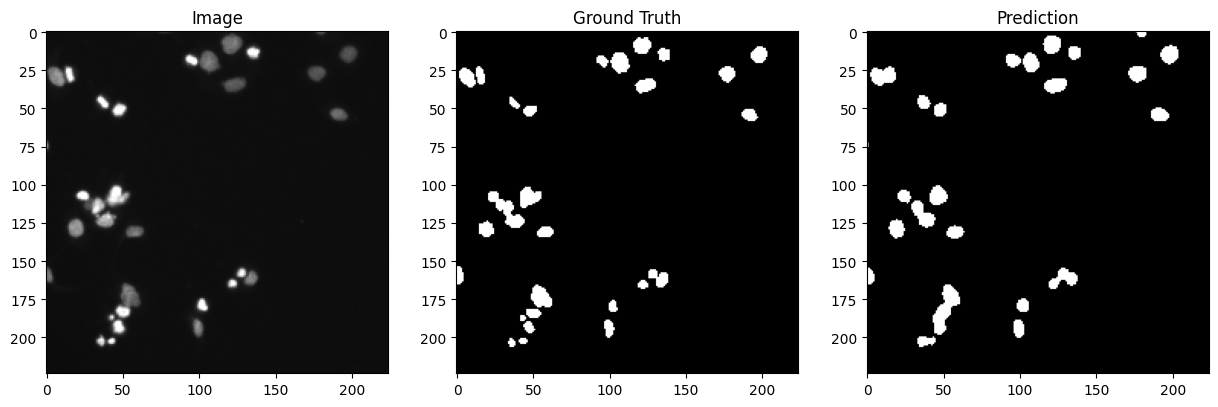

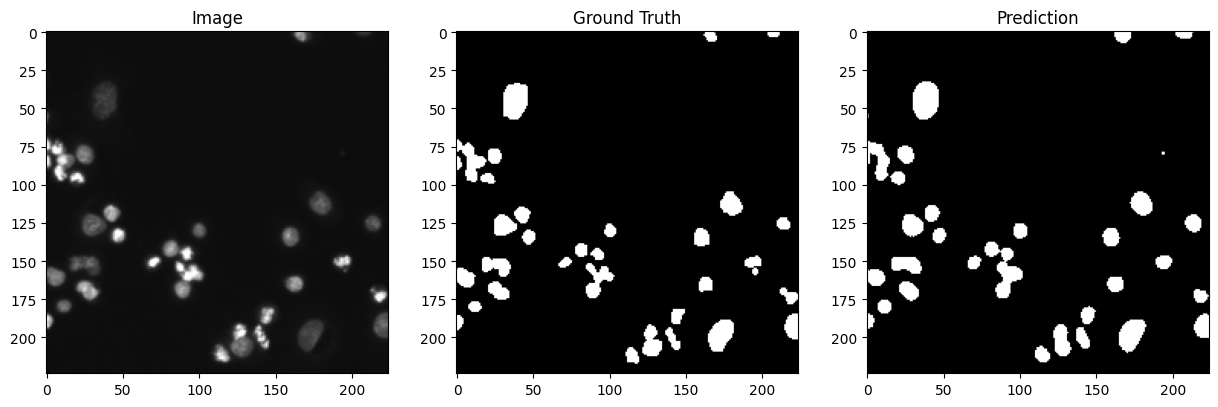


Epoch [8/20]


Train Loss: 0.4492 | Dice: 0.8004 | IoU: 0.6728
Val Loss: 0.4229 | Dice: 0.8255 | IoU: 0.7041

Epoch [9/20]


Train Loss: 0.4504 | Dice: 0.7758 | IoU: 0.6439
Val Loss: 0.4673 | Dice: 0.7494 | IoU: 0.5994

Epoch [10/20]


Train Loss: 0.4318 | Dice: 0.7844 | IoU: 0.6496
Val Loss: 0.4246 | Dice: 0.8489 | IoU: 0.7398


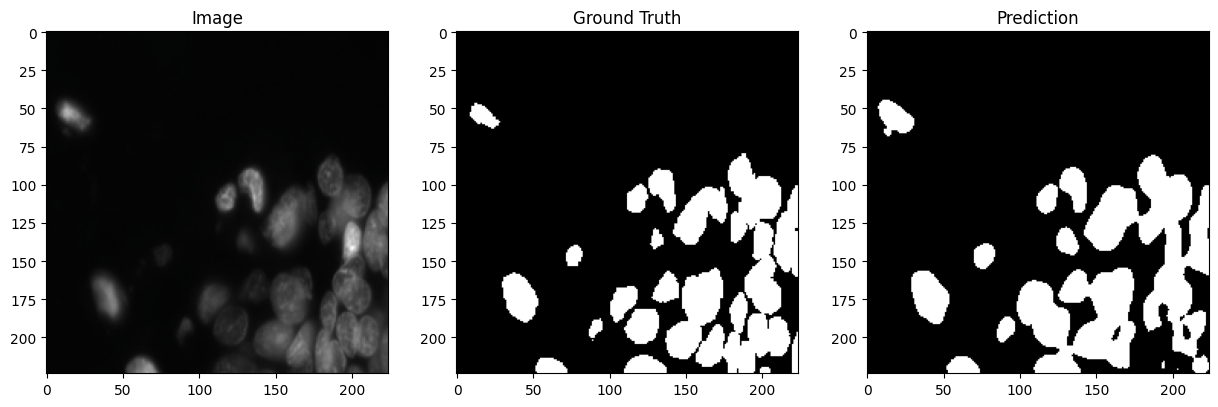

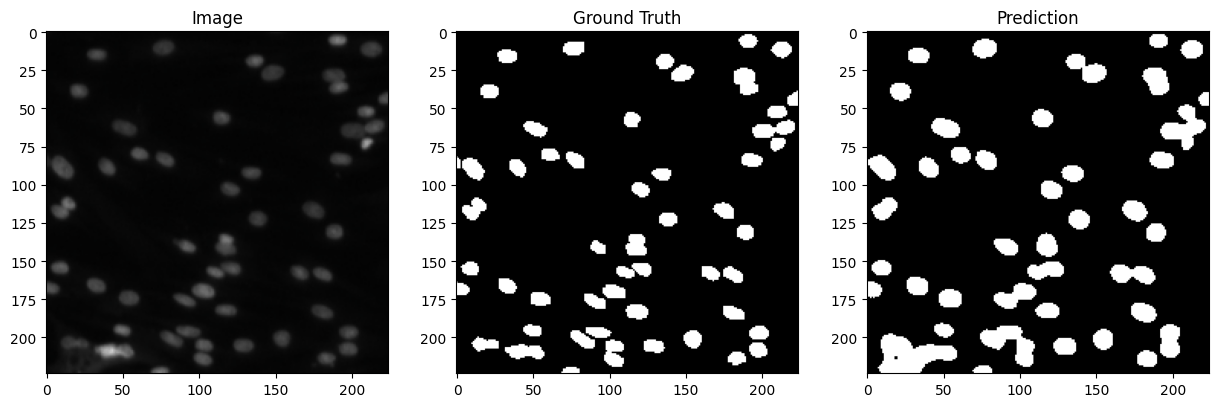

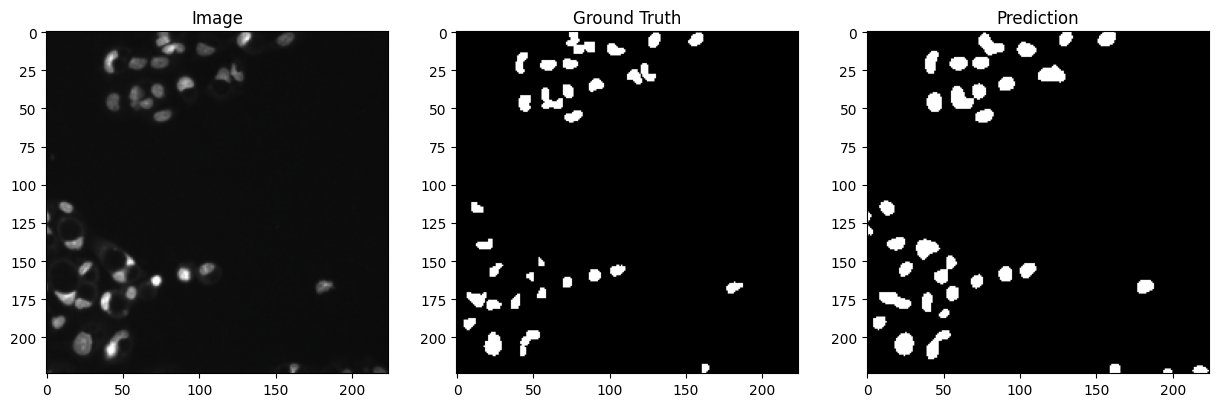

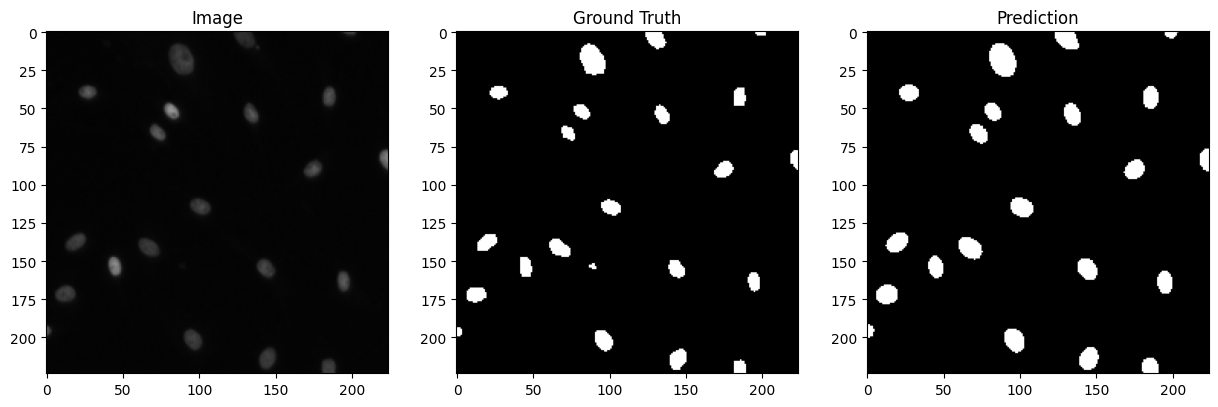

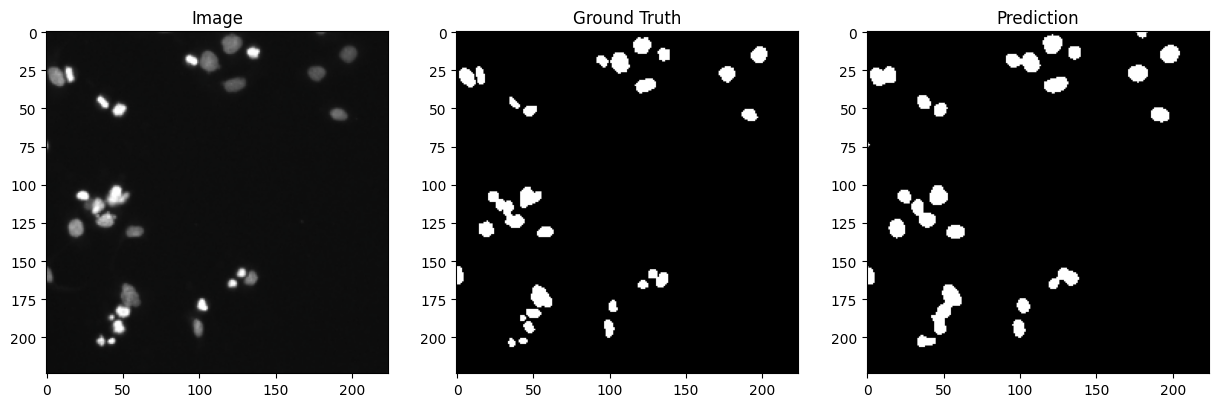

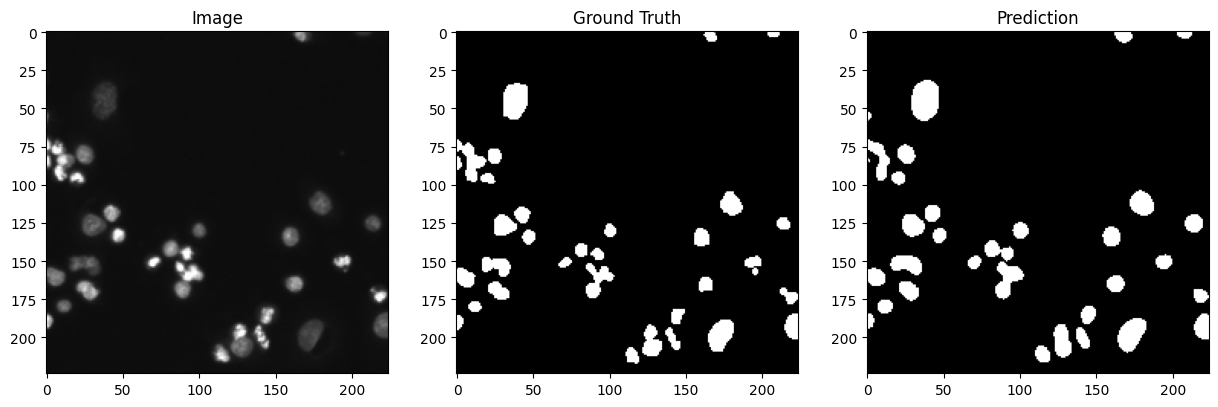


Epoch [11/20]


Train Loss: 0.4275 | Dice: 0.7808 | IoU: 0.6481
Val Loss: 0.3872 | Dice: 0.8399 | IoU: 0.7254

Epoch [12/20]


Train Loss: 0.4051 | Dice: 0.8139 | IoU: 0.6916
Val Loss: 0.3892 | Dice: 0.8387 | IoU: 0.7245

Epoch [13/20]


Train Loss: 0.3969 | Dice: 0.8144 | IoU: 0.6902
Val Loss: 0.3791 | Dice: 0.8384 | IoU: 0.7240

Epoch [14/20]


Train Loss: 0.3944 | Dice: 0.7967 | IoU: 0.6668
Val Loss: 0.3975 | Dice: 0.8147 | IoU: 0.6888

Epoch [15/20]


Train Loss: 0.3860 | Dice: 0.8156 | IoU: 0.6936
Val Loss: 0.3731 | Dice: 0.8485 | IoU: 0.7379
Early stopping


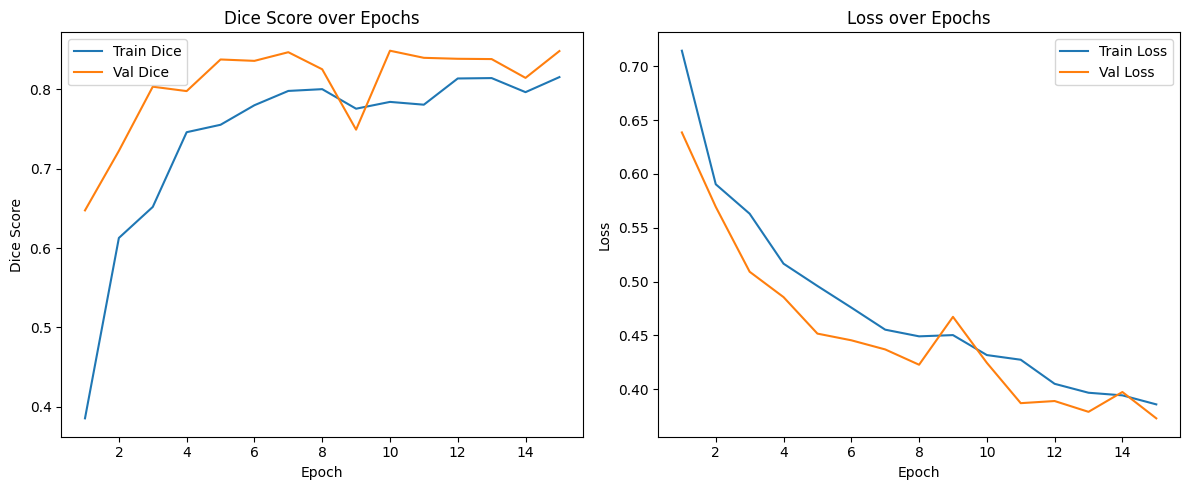

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from albumentations import Compose, Resize, Normalize, HorizontalFlip, RandomRotate90, ElasticTransform, RandomCrop, ColorJitter, GaussNoise
from albumentations.pytorch import ToTensorV2
from PIL import Image
import os

# Custom Dataset
class CellDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        assert len(self.image_filenames) == len(self.mask_filenames), \
            f"Mismatch: {len(self.image_filenames)} images, {len(self.mask_filenames)} masks"

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.image_filenames[index])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask = (mask / 255.0).clip(0, 1)  # Normalize to [0, 1]
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]
        return image, mask

# Data Transforms
train_transform = Compose([
    Resize(256, 256),
    HorizontalFlip(p=0.5),
    RandomRotate90(p=0.5),
    ElasticTransform(p=0.3, alpha=120, sigma=120 * 0.05),
    RandomCrop(height=224, width=224, p=1.0), # Apply RandomCrop with p=1.0
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    GaussNoise(var_range=(10.0, 50.0), p=0.2), # Corrected argument
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = Compose([
    Resize(224, 224), # Resize to match training input size
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# U-Net Model
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False), #Padding=1:Shape preserved , #Padding=0 : shape changes
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.encoder1 = DoubleConv(in_channels, 64)
        self.encoder2 = DoubleConv(64, 128)
        self.encoder3 = DoubleConv(128, 256)
        self.encoder4 = DoubleConv(256, 512)
        self.bottleneck = DoubleConv(512, 1024)
        self.pool = nn.MaxPool2d(2)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(128, 64)
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.upconv4(b)
        d4 = self.decoder4(torch.cat([d4, e4], dim=1))
        d3 = self.upconv3(d4)
        d3 = self.decoder3(torch.cat([d3, e3], dim=1))
        d2 = self.upconv2(d3)
        d2 = self.decoder2(torch.cat([d2, e2], dim=1))
        d1 = self.upconv1(d2)
        d1 = self.decoder1(torch.cat([d1, e1], dim=1))
        return self.out_conv(d1)

# Loss and Metrics
def dice_loss(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    return 1 - ((2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth))

def combined_loss(preds, targets, bce_weight=0.5):
    bce = nn.BCEWithLogitsLoss()(preds, targets)
    dice = dice_loss(preds, targets)
    return bce_weight * bce + (1 - bce_weight) * dice

def dice_score(preds, targets, threshold=0.5, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def iou_score(preds, targets, threshold=0.5, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    union = (preds + targets).clamp(0, 1).sum()
    return (intersection + smooth) / (union + smooth)

# Training and Evaluation Functions
def train_fn(loader, model, optimizer, loss_fn, device):
    model.train()
    loop = tqdm(loader, desc="Training", leave=False)
    total_loss, total_dice, total_iou = 0.0, 0.0, 0.0
    for data, targets in loop:
        data, targets = data.to(device), targets.to(device).unsqueeze(1)
        preds = model(data)
        loss = loss_fn(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_dice += dice_score(preds, targets).item()
        total_iou += iou_score(preds, targets).item()
        loop.set_postfix(loss=loss.item(), dice=dice_score(preds, targets).item())
    return total_loss / len(loader), total_dice / len(loader), total_iou / len(loader)

def eval_fn(loader, model, loss_fn, device):
    model.eval()
    total_loss, total_dice, total_iou = 0.0, 0.0, 0.0
    with torch.no_grad():
        loop = tqdm(loader, desc="Validating", leave=False)
        for data, targets in loop:
            data, targets = data.to(device), targets.to(device).unsqueeze(1)
            preds = model(data)
            loss = loss_fn(preds, targets)
            total_loss += loss.item()
            total_dice += dice_score(preds, targets).item()
            total_iou += iou_score(preds, targets).item()
            loop.set_postfix(val_loss=loss.item(), val_dice=dice_score(preds, targets).item())
    return total_loss / len(loader), total_dice / len(loader), total_iou / len(loader)

# Visualize Predictions
def visualize_predictions(model, loader, device, num_samples=3):
    model.eval()
    data_iter = iter(loader)
    with torch.no_grad():
        for _ in range(num_samples):
            data, targets = next(data_iter)
            data, targets = data.to(device), targets.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(data)) > 0.5
            for i in range(min(data.shape[0], 2)):
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                # Denormalize for visualization
                img_display = data[i].cpu().permute(1, 2, 0).numpy()
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img_display = std * img_display + mean
                img_display = np.clip(img_display, 0, 1)
                plt.imshow(img_display)
                plt.title("Image")
                plt.subplot(1, 3, 2)
                plt.imshow(targets[i, 0].cpu().numpy(), cmap='gray')
                plt.title("Ground Truth")
                plt.subplot(1, 3, 3)
                plt.imshow(preds[i, 0].cpu().numpy(), cmap='gray')
                plt.title("Prediction")
                plt.show()

# Main
def main():
    # Data
    train_dataset = CellDataset(
        image_dir='/content/drive/MyDrive/Cell/AACell_train_final/images',
        mask_dir='/content/drive/MyDrive/Cell/AACell_train_final/masks',
        transform=train_transform
    )
    val_dataset = CellDataset(
        image_dir='/content/drive/MyDrive/Cell/Acell_validation/val_images',
        mask_dir='/content/drive/MyDrive/Cell/Acell_validation/val_masks',
        transform=val_transform
    )
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
    print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

    # Visualize data
    for i in range(3):
        img, mask = train_dataset[i]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        # Denormalize for visualization
        img_display = img.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_display = std * img_display + mean
        img_display = np.clip(img_display, 0, 1)
        plt.imshow(img_display)
        plt.title("Image")
        plt.subplot(1, 2, 2)
        plt.imshow(mask.numpy(), cmap='gray')
        plt.title(f"Mask (mean: {mask.mean():.4f})")
        plt.show()


    # Model and training setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet(in_channels=3, out_channels=1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    # Training loop
    epochs = 20
    best_val_dice = 0
    patience = 5
    counter = 0
    train_losses, val_losses, train_dices, val_dices = [], [], [], []
    for epoch in range(epochs):
        print(f"\nEpoch [{epoch+1}/{epochs}]")
        train_loss, train_dice, train_iou = train_fn(train_loader, model, optimizer, combined_loss, device)
        val_loss, val_dice, val_iou = eval_fn(val_loader, model, combined_loss, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_dices.append(train_dice)
        val_dices.append(val_dice)
        print(f"Train Loss: {train_loss:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")
        scheduler.step(val_loss)
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), 'best_model.pt')
            counter = 0
            visualize_predictions(model, val_loader, device)  # Visualize predictions for best model
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break

    # Plot metrics
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_dices) + 1), train_dices, label='Train Dice', color='#1f77b4')
    plt.plot(range(1, len(val_dices) + 1), val_dices, label='Val Dice', color='#ff7f0e')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Dice Score over Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='#1f77b4')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', color='#ff7f0e')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')